In [1]:
import os
import sys
import subprocess
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mplimage
import matplotlib.patches as mplpatches
import matplotlib.lines as mpllines
import matplotlib.collections as mplcollections
import matplotlib.colors as mplcolors
import matplotlib.transforms as mpltransforms
from scipy.stats import gaussian_kde, linregress

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle
ccycle = cosmostyle.color_cycle

In [2]:
def cc(x, p):
    """
        Compute the Pearson correlation coefficient
        
        ---Arguments---
        x: feature data (e.g., SOAP KPCA)
        p: property data (e.g., decomposed volumes)
    """
    return np.dot(p-p.mean(), x-x.mean())/(np.std(p)*np.std(x)*len(p))

def load_framework_data(filename):
    """
        Parse data about the zeolite frameworks
        
        ---Arguments---
        filename: filename containing the zeolite structure data
            (from atomLabels.py)
    """
    
    # Initialize containers for framework properties
    framework_energies = []
    framework_volumes = []
    structure_idxs = []
    
    # Parse the framework data from the file
    with open(filename, 'r') as f:
        for line in f:
            data = line.strip().split()
            structure_idxs.append(int(data[7]))
            framework_volumes.append(float(data[8]))
            framework_energies.append(float(data[9]))

    # Convert to numpy arrays
    framework_energies = np.asarray(framework_energies)
    framework_volumes = np.asarray(framework_volumes)
    structure_idxs = np.asarray(structure_idxs)

    # Get the volumes and energies of the frameworks using
    # np.unique on the framework indices
    s, ss, sc = np.unique(structure_idxs, return_counts=True, return_index=True)
    
    # Volumes per Si
    framework_volumes = framework_volumes[ss]/sc
    
    # Mean-center the energies per Si
    framework_energies = framework_energies[ss]*sc
    framework_energies -= np.mean(framework_energies/(sc*3))*(sc*3)
    framework_energies /= sc
    
    return framework_volumes, framework_energies, structure_idxs

def build_ellipse(v, e, ax, s=1, **kwargs):
    """
        Build an error ellipse (unused)
        
        References, adapted from:
            https://matplotlib.org/3.1.0/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
            https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html
            http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix
        
        ---Arguments---
        v: volume data (x data)
        e: energy data (y data)
        ax: matplotlib figure axis on which to plot the ellipse
        s: scale factor for covariance
        kwargs: optional arguments for matplotlib's Ellipse
    """
    
    # Compute (scaled) covariance, means, and the parameter
    # p for determining ellipse height and width
    c = s*np.cov(v, e)
    p = c[0, 1]/(np.sqrt(c[0, 0])*np.sqrt(c[1, 1]))
    v_mean = np.mean(v)
    e_mean = np.mean(e)
    
    # Compute ellipse height and width
    w = 2*np.sqrt(1+p)
    h = 2*np.sqrt(1-p)
    E = mplpatches.Ellipse(xy=(0, 0), width=w, height=h, angle=0, **kwargs)
    
    # Scale the ellipse and transform to obtain proper rotation
    scale_w = np.sqrt(c[0, 0])
    scale_h = np.sqrt(c[1, 1])
    transf = mpltransforms.Affine2D().rotate_deg(45).scale(scale_w, scale_h).translate(v_mean, e_mean)
    E.set_transform(transf + ax.transData)
   
    return E

def build_ellipse_eig(v, e, ax):
    """
        Build an error ellipse based on eigenvalues (unused)
        
        Reference, adapted from:
            https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
            
        ---Arguments---
        v: volume data (x data)
        e: energy data (y data)
        ax: matplotlib figure axis on which to plot the ellipse
    """

    # Compute covariance matrix and its eigenvalues
    c = np.cov(v, e)
    eigval, eigvec = np.linalg.eigh(c)
    
    # Largest eigenvalue
    w = 2*np.sqrt(eigval[1])
    
    # Smallest eigenvalue
    h = 2*np.sqrt(eigval[0])
    
    # Rotation of ellipse based on eigenvector of larges eigenvalue
    r = np.arctan2(eigvec[1, 1], eigvec[0, 1])
    E = mplpatches.Ellipse(xy=(np.mean(v), np.mean(e)), width=w, height=h, angle=180.0/np.pi*r)
    return E

# Correlation Plots

Be sure to note that there may be outliers that don't show up in the KDE!

## 1k Data

In [3]:
# Load the data
kpca_1k_6A = np.load('../Processed_Data/DEEM_1k/PCA/6.0/kpca-0.npy')
volumes_1k_6A = np.loadtxt('../Processed_Data/DEEM_1k/Volume/6.0/Gaussian/envProperties-0.dat')
energies_1k_6A = np.loadtxt('../Processed_Data/DEEM_1k/Energy/6.0/Gaussian/envProperties-0.dat')

kpca_1k_3A = np.load('../Processed_Data/DEEM_1k/PCA/3.5/kpca-0.npy')
volumes_1k_3A = np.loadtxt('../Processed_Data/DEEM_1k/Volume/3.5/Gaussian/envProperties-0.dat')
energies_1k_3A = np.loadtxt('../Processed_Data/DEEM_1k/Energy/3.5/Gaussian/envProperties-0.dat')

angles_1k = np.loadtxt('../Processed_Data/DEEM_1k/Angles/angles.dat')
distances_1k = np.loadtxt('../Processed_Data/DEEM_1k/Distances/distances.dat')

In [4]:
# Compute variance of properties and KPCA representation
var3 = kpca_1k_3A.var(axis=0)
var6 = kpca_1k_6A.var(axis=0)
varA = angles_1k.var(axis=0)
varD = distances_1k.var(axis=0)

# Initialize arrays to store the correlation coefficients
ccV3 = np.zeros(len(var3))
ccV6 = np.zeros(len(var6))
ccE3 = np.zeros(len(var3))
ccE6 = np.zeros(len(var6))

ccAV3 = np.zeros(len(varA))
ccAV6 = np.zeros(len(varA))
ccAE3 = np.zeros(len(varA))
ccAE6 = np.zeros(len(varA))
ccDV3 = np.zeros(len(varD))
ccDV6 = np.zeros(len(varD))
ccDE3 = np.zeros(len(varD))
ccDE6 = np.zeros(len(varD))

# Compute correlation coefficients
for i in range(0, kpca_1k_3A.shape[1]):
    ccE3[i] = cc(kpca_1k_3A[:, i], energies_1k_3A)
    ccV3[i] = cc(kpca_1k_3A[:, i], volumes_1k_3A)
    
for i in range(0, kpca_1k_6A.shape[1]):    
    ccE6[i] = cc(kpca_1k_6A[:, i], energies_1k_6A)
    ccV6[i] = cc(kpca_1k_6A[:, i], volumes_1k_6A)
    
for i in range(0, angles_1k.shape[1]):
    ccAE3[i] = cc(angles_1k[:, i], energies_1k_3A)
    ccAE6[i] = cc(angles_1k[:, i], energies_1k_6A)
    ccAV3[i] = cc(angles_1k[:, i], volumes_1k_3A)
    ccAV6[i] = cc(angles_1k[:, i], volumes_1k_6A)
    
for i in range(0, distances_1k.shape[1]):    
    ccDE3[i] = cc(distances_1k[:, i], energies_1k_3A)
    ccDE6[i] = cc(distances_1k[:, i], energies_1k_6A)
    ccDV3[i] = cc(distances_1k[:, i], volumes_1k_3A)
    ccDV6[i] = cc(distances_1k[:, i], volumes_1k_6A)

In [6]:
# Compute explained variance ratio
print var3[0:3]/var3.sum()
print var6[0:3]/var6.sum()

[0.50473965 0.13484477 0.06013719]
[0.24331539 0.18121387 0.15777425]


In [7]:
for i in range(0, 50):
    print np.sum(var3[:i])/np.sum(var3)

0.0
0.504739645615537
0.6395844126366396
0.6997216031408846
0.7434145297135486
0.7781402735847059
0.8091626815144689
0.8332432463810147
0.8548440882131043
0.8699116501202635
0.8828735945778139
0.8911834780666882
0.8992350848938563
0.9063166019209774
0.9123822484067811
0.9178121377621318
0.922715542499681
0.9270585566767654
0.9310518287015428
0.9347399876658852
0.937850315521193
0.9407579245941129
0.943526344177109
0.9461631432146396
0.9486670289340834
0.9510658847233385
0.9531118704392799
0.9550278242546963
0.9567889271403309
0.9584604142868544
0.9600276884369777
0.9615246184902033
0.9629329775383537
0.9642258604650651
0.9654746221688716
0.9666616187050634
0.9677945845590242
0.9688416715606168
0.9698200725688675
0.9707582199177032
0.9716652317357577
0.9725112233783415
0.9732792929858112
0.9740355212002091
0.9747613064350916
0.9754295388671035
0.9760947409650597
0.9767370483806913
0.9773587113752591
0.9779571471313683


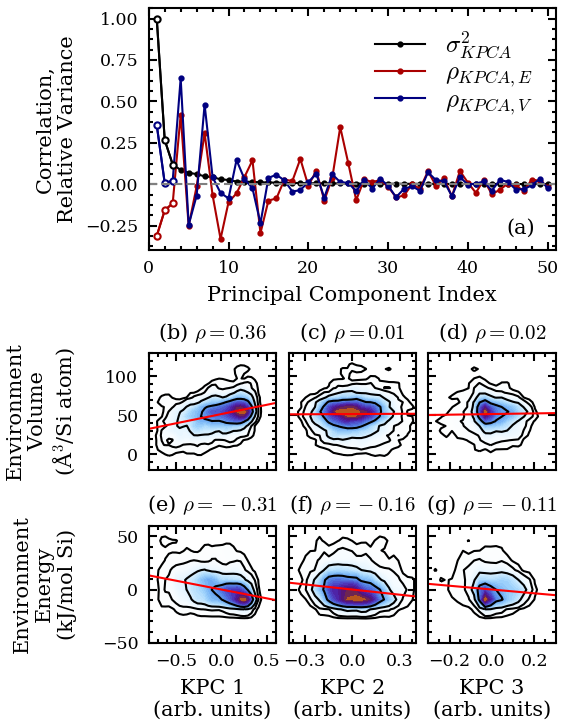

In [53]:
### DEEM 1k, SOAP 3.5 correlation plots ###

# Number of KPCA components and KDE grid divisions
nPCA = 50
n_grid = 40

# Plot labels
plot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

# KPC labels
x = np.arange(1, nPCA+1)

# Initialize figure with Gridspec
fig3 = plt.figure(figsize=(3.5, 5.5))
gs_data = mpl.gridspec.GridSpec(7, 3, height_ratios=(3, 3, 1, 1, 3, 1, 3), hspace=0.1, wspace=0.1)
axs3 = fig3.add_subplot(gs_data[0:2, :])

# Plot explained variance and energy/volume correlation
axs3.plot(x, var3[0:nPCA]/var3[0], marker='o', label=r'$\sigma^2_{KPCA}$')
axs3.plot(x, ccE3[0:nPCA], marker='o', label=r'$\rho_{KPCA, E}$')
axs3.plot(x, ccV3[0:nPCA], marker='o', label=r'$\rho_{KPCA, V}$')

# Reset property cycle
axs3.set_prop_cycle(None)

# Plot empty markers for first three components
axs3.plot(x[0:3], var3[0:3]/var3[0], marker='o', markerfacecolor='w', markersize=3)
axs3.plot(x[0:3], ccE3[0:3], marker='o', markerfacecolor='w', markersize=3)
axs3.plot(x[0:3], ccV3[0:3], marker='o', markerfacecolor='w', markersize=3)

# Axes labels and limits
axs3.set_xlabel('Principal Component Index')
axs3.set_ylabel('Correlation,\nRelative Variance')
axs3.axhline(y=0, linestyle='--', color='grey')
axs3.set_xlim((0, 51))

# Plot labels
axs3.text(0.95, 0.05, '%s' % plot_labels[0], 
          horizontalalignment='right', verticalalignment='bottom', transform=axs3.transAxes)

# Legend
axs3.legend(fontsize='large', labelspacing=0)

# Initialize KDE property grids
yV = np.linspace(volumes_1k_3A.min()-volumes_1k_3A.std(), 
                 volumes_1k_3A.max()+volumes_1k_3A.std(), n_grid)
yE = np.linspace(energies_1k_3A.min()-energies_1k_3A.std(), 
                 energies_1k_3A.max()+energies_1k_3A.std(), n_grid)

## Volume KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsVol = fig3.add_subplot(gs_data[4, i])
    axsVol_label = fig3.add_subplot(gs_data[3, i])
    
    # Remove borders from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsVol_label.spines[j].set_visible(False)
    
    # Tick parameters
    axsVol_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    
    # Initialize KDE data grid
    x = np.linspace(kpca_1k_3A[:, i].min()-kpca_1k_3A[:, i].std(), 
                kpca_1k_3A[:, i].max()+kpca_1k_3A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yV)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_1k_3A[:, i], volumes_1k_3A]))
    zz = np.reshape(kde(pos).T, xx.shape)

    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsVol.contourf(xx, yy, zz, levels=levelsf)
    axsVol.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_1k_3A[:, i], volumes_1k_3A)
    axsVol.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsVol.set_ylabel('Environment\nVolume\n' + ur'(\u00c5$^3$/Si atom)')
    else:
        axsVol.set_yticklabels([])
    
    axsVol.set_xticklabels([])
        
    # Set axes limits
    if i == 0:
        axsVol.set_xlim([-0.8, 0.6])
        axsVol.set_xticks([-0.5, 0.0, 0.5])
    elif i == 1:
        axsVol.set_xlim([-0.4, 0.4])
        axsVol.set_xticks([-0.3, 0.0, 0.3])
    else:
        axsVol.set_xlim([-0.3, 0.3])
        axsVol.set_xticks([-0.2, 0.0, 0.2])
        
    axsVol.set_ylim([-20, 130])

    # Plot labels
    axsVol_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+1], ccV3[i]),
                horizontalalignment='center', verticalalignment='bottom', transform=axsVol_label.transAxes)

## Energy KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsE = fig3.add_subplot(gs_data[6, i])
    axsE_label = fig3.add_subplot(gs_data[5, i])
    
    # Remove border from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsE_label.spines[j].set_visible(False)
        
    # Tick parameters
    axsE_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    
    # Initialize KDE data grid
    x = np.linspace(kpca_1k_3A[:, i].min()-kpca_1k_3A[:, i].std(), 
                kpca_1k_3A[:, i].max()+kpca_1k_3A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yE)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_1k_3A[:, i], energies_1k_3A]))
    zz = np.reshape(kde(pos).T, xx.shape)

    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsE.contourf(xx, yy, zz, levels=levelsf)
    axsE.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_1k_3A[:, i], energies_1k_3A)
    axsE.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsE.set_ylabel('Environment\nEnergy\n(kJ/mol Si)')
    else:
        axsE.set_yticklabels([])
    
    axsE.set_xlabel('KPC %d\n(arb. units)' % (i+1))
    
    # Axes limits
    if i == 0:
        axsE.set_xlim([-0.8, 0.6])
        axsE.set_xticks([-0.5, 0.0, 0.5])
    elif i == 1:
        axsE.set_xlim([-0.4, 0.4])
        axsE.set_xticks([-0.3, 0.0, 0.3])
    else:
        axsE.set_xlim([-0.3, 0.3])
        axsE.set_xticks([-0.2, 0.0, 0.2])
        
    axsE.set_ylim([-50, 60])
    
    # Plot labels
    axsE_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+4], ccE3[i]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsE_label.transAxes)
    
fig3.align_ylabels()
fig3.savefig('../Results/DEEM_1k/kpca_energy-volume-correlation_3.5_1k.pdf', bbox_inches='tight')

plt.show()

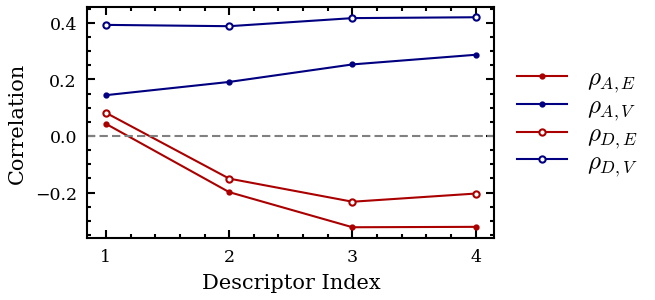

In [54]:
### Correlation coefficient with the classical descriptors ###
### DEEM 1k, SOAP 3.5 ###

# Descriptor index labels
x = np.arange(1, angles_1k.shape[1]+1)

# Initialize figure and axes
fig3 = plt.figure(figsize=(3.5, 2.0))
axs3 = fig3.add_subplot(1, 1, 1)

# Plot correlation coefficients
axs3.plot(x, ccAE3, marker='o', c=ccycle[1], label=r'$\rho_{A, E}$')
axs3.plot(x, ccAV3, marker='o', c=ccycle[2], label=r'$\rho_{A, V}$')
axs3.plot(x, ccDE3, marker='o', c=ccycle[1], markerfacecolor='w', markersize=3, label=r'$\rho_{D, E}$')
axs3.plot(x, ccDV3, marker='o', c=ccycle[2], markerfacecolor='w', markersize=3, label=r'$\rho_{D, V}$')

# Axes labels and ticks
axs3.set_xlabel('Descriptor Index')
axs3.set_ylabel('Correlation')
axs3.axhline(y=0, linestyle='--', color='grey')
axs3.set_xticks([1, 2, 3, 4])

# Legend
axs3.legend(fontsize='large', labelspacing=0, loc='center left', bbox_to_anchor=(1.0, 0.5))

#fig3.savefig('../Results/DEEM_1k/correlation_classical_3.5_1k.pdf', bbox_inches='tight')
plt.show()

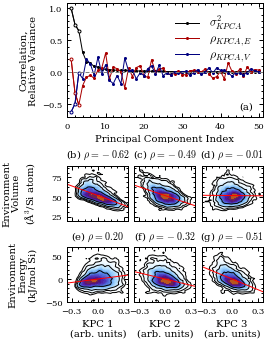

In [5]:
### DEEM 1k, SOAP 6.0 correlation plots ###

# Number of KPCA components and KDE grid divisions
nPCA = 50
n_grid = 40

# Plot labels
plot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

# KPC labels
x = np.arange(1, nPCA+1)
fig6 = plt.figure(figsize=(3.5, 5.5))

# Initialize subplots with Gridspec
gs_data = mpl.gridspec.GridSpec(7, 3, height_ratios=(3, 3, 1, 1, 3, 1, 3), hspace=0.1, wspace=0.1)
axs6 = fig6.add_subplot(gs_data[0:2, :])

# Plot explained variance and energy/volume correlation
axs6.plot(x, var6[0:nPCA]/var6[0], marker='o', label=r'$\sigma^2_{KPCA}$')
axs6.plot(x, ccE6[0:nPCA], marker='o', label=r'$\rho_{KPCA, E}$')
axs6.plot(x, ccV6[0:nPCA], marker='o', label=r'$\rho_{KPCA, V}$')

# Reset property cycle
axs6.set_prop_cycle(None)

# Plot empty markers for the first three components
axs6.plot(x[0:3], var6[0:3]/var6[0], marker='o', markerfacecolor='w', markersize=3)
axs6.plot(x[0:3], ccE6[0:3], marker='o', markerfacecolor='w', markersize=3)
axs6.plot(x[0:3], ccV6[0:3], marker='o', markerfacecolor='w', markersize=3)

# Axes labels and limits
axs6.set_xlabel('Principal Component Index')
axs6.set_ylabel('Correlation,\nRelative Variance')
axs6.axhline(y=0, linestyle='--', color='grey')
axs6.set_xlim((0, 51))

# Plot labels
axs6.text(0.95, 0.05, '%s' % plot_labels[0], 
          horizontalalignment='right', verticalalignment='bottom', transform=axs6.transAxes)

# Legend
axs6.legend(fontsize='large', labelspacing=0)

# Initialize KDE property grids
yV = np.linspace(volumes_1k_6A.min()-volumes_1k_6A.std(),
                 volumes_1k_6A.max()+volumes_1k_6A.std(), n_grid)
yE = np.linspace(energies_1k_6A.min()-energies_1k_6A.std(),
                 energies_1k_6A.max()+energies_1k_6A.std(), n_grid)

## Volume Correlation ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsVol = fig6.add_subplot(gs_data[4, i])
    axsVol_label = fig6.add_subplot(gs_data[3, i])
    
    # Remove borders from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsVol_label.spines[j].set_visible(False)
    
    # Tick parameters
    axsVol_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)

    # Initialize KDE data grid
    x = np.linspace(kpca_1k_6A[:, i].min()-kpca_1k_6A[:, i].std(), 
                    kpca_1k_6A[:, i].max()+kpca_1k_6A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yV)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_1k_6A[:, i], volumes_1k_6A]))
    zz = np.reshape(kde(pos).T, xx.shape)

    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsVol.contourf(xx, yy, zz, levels=levelsf)
    axsVol.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_1k_6A[:, i], volumes_1k_6A)
    axsVol.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsVol.set_ylabel('Environment\nVolume\n' + ur'(\u00c5$^3$/Si atom)')
    else:
        axsVol.set_yticklabels([])
    
    axsVol.set_xticklabels([])
    
    # Set axes limits
    axsVol.set_xlim([-0.35, 0.35])
    axsVol.set_xticks([-0.3, 0.0, 0.3])
    axsVol.set_ylim([20, 90])
    
    # Plot labels
    axsVol_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+1], ccV6[i]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsVol_label.transAxes)
    
## Energy KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsE = fig6.add_subplot(gs_data[6, i])
    axsE_label = fig6.add_subplot(gs_data[5, i])
    
    # Remove border from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsE_label.spines[j].set_visible(False)
        
    # Tick parameters
    axsE_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)

    # Initialize KDE data grid
    x = np.linspace(kpca_1k_6A[:, i].min()-kpca_1k_6A[:, i].std(), 
                    kpca_1k_6A[:, i].max()+kpca_1k_6A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yE)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_1k_6A[:, i], energies_1k_6A]))
    zz = np.reshape(kde(pos).T, xx.shape)
    
    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsE.contourf(xx, yy, zz, levels=levelsf)
    axsE.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_1k_6A[:, i], energies_1k_6A)
    axsE.plot(x, m*x+b, linestyle='-', color='r')
        
    # Set tick and axes labels   
    if i == 0:
        axsE.set_ylabel('Environment\nEnergy\n(kJ/mol Si)')
    else:
        axsE.set_yticklabels([])
    
    axsE.set_xlabel('KPC %d\n(arb. units)' % (i+1))
    
    # Axes limits
    axsE.set_xlim([-0.35, 0.35])
    axsE.set_xticks([-0.3, 0.0, 0.3])
    
    axsE.set_ylim([-50, 70])
    
    # Plot labels
    axsE_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+4], ccE6[i]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsE_label.transAxes)

fig6.align_ylabels()
fig6.savefig('../Results/DEEM_1k/kpca_energy-volume-correlation_6.0_1k.pdf', bbox_inches='tight')
plt.show()

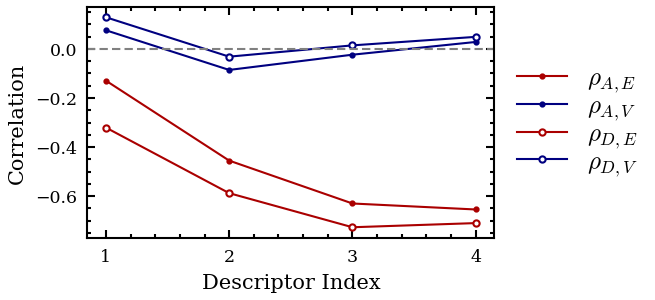

In [56]:
### Correlation coefficient with the classical descriptors ###
### DEEM 1k, SOAP 6.0 ###

# Descriptor index labels
x = np.arange(1, angles_1k.shape[1]+1)

# Initialize figure and axes
fig6 = plt.figure(figsize=(3.5, 2.0))
axs6 = fig6.add_subplot(1, 1, 1)

# Plot correlation coefficients
axs6.plot(x, ccAE6, marker='o', c=ccycle[1], label=r'$\rho_{A, E}$')
axs6.plot(x, ccAV6, marker='o', c=ccycle[2], label=r'$\rho_{A, V}$')
axs6.plot(x, ccDE6, marker='o', c=ccycle[1], markerfacecolor='w', markersize=3, label=r'$\rho_{D, E}$')
axs6.plot(x, ccDV6, marker='o', c=ccycle[2], markerfacecolor='w', markersize=3, label=r'$\rho_{D, V}$')

# Axes labels and ticks
axs6.set_xlabel('Descriptor Index')
axs6.set_ylabel('Correlation')
axs6.axhline(y=0, linestyle='--', color='grey')
axs6.set_xticks([1, 2, 3, 4])

# Legend
axs6.legend(fontsize='large', labelspacing=0, loc='center left', bbox_to_anchor=(1.0, 0.5))

#fig6.savefig('../Results/DEEM_1k/correlation_classical_6.0_1k.pdf', bbox_inches='tight')
plt.show()

## 10k Data

In [7]:
# Compute correlation coefficient iteratively (DEEM 10k, SOAP 3.5)
#
# Online variance algorithm adapted from:
# https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance
# http://jonisalonen.com/2013/deriving-welfords-method-for-computing-variance/
# https://www.johndcook.com/blog/standard_deviation/

# Initialize number of environments, batches,
# and containers for the KPCA and property data
n = 0
nBatch = 10
energies_10k_3A = []
volumes_10k_3A = []
kpca_10k_3A = []

# Loop over batches
for i in range(0, nBatch):
    
    # Load KPCA and property data and append to their respective containers
    ikpca_10k_3A = np.load('../Processed_Data/DEEM_10k/PCA/3.5/kpca-%d.npy' % i)
    ivol = np.loadtxt('../Processed_Data/DEEM_10k/Volume/3.5/Gaussian/envProperties-%d.dat' % i)
    ienergy = np.loadtxt('../Processed_Data/DEEM_10k/Energy/3.5/Gaussian/envProperties-%d.dat' % i)
    energies_10k_3A.append(ienergy)
    volumes_10k_3A.append(ivol)
    kpca_10k_3A.append(ikpca_10k_3A[:, 0:3])

    # Initialize means and variances
    if i == 0:
        var3 = np.zeros(ikpca_10k_3A.shape[1])
        mean3 = np.zeros(ikpca_10k_3A.shape[1])
        varE3 = 0
        meanE3 = 0
        varV3 = 0
        meanV3 = 0
        
    # Iteratively compute the mean and variance
    for j in range(0, ikpca_10k_3A.shape[0]):
        n += 1
        mean3_old = mean3.copy()
        mean3 += (ikpca_10k_3A[j, :]-mean3)/n
        var3 += (ikpca_10k_3A[j, :]-mean3)*(ikpca_10k_3A[j, :]-mean3_old)
            
        meanE3_old = meanE3
        meanE3 += (ienergy[j]-meanE3)/n
        varE3 += (ienergy[j]-meanE3)*(ienergy[j]-meanE3_old)
            
        meanV3_old = meanV3
        meanV3 += (ivol[j]-meanV3)/n
        varV3 += (ivol[j]-meanV3)*(ivol[j]-meanV3_old)

# Concatenate the data into a single matrix
energies_10k_3A = np.concatenate(energies_10k_3A)
volumes_10k_3A = np.concatenate(volumes_10k_3A)
kpca_10k_3A = np.concatenate(kpca_10k_3A)

# Finalize the variances
var3 /= n
varE3 /= n
varV3 /= n

# Calculate correlation coefficients for the properties
ccV3 = np.zeros(len(var3))
ccE3 = np.zeros(len(var3))

# Re-load the batched data
for i in range(0, nBatch):
    ikpca_10k_3A = np.load('../Processed_Data/DEEM_10k/PCA/3.5/kpca-%d.npy' % i)
    ivol = np.loadtxt('../Processed_Data/DEEM_10k/Volume/3.5/Gaussian/envProperties-%d.dat' % i)
    ienergy = np.loadtxt('../Processed_Data/DEEM_10k/Energy/3.5/Gaussian/envProperties-%d.dat' % i)

    # Compute correlation coefficients for the KPCA data
    for j in range(0, ikpca_10k_3A.shape[1]):    
        ccE3[j] += np.dot(ienergy-meanE3, ikpca_10k_3A[:, j]-mean3[j])/(np.sqrt(varE3*var3[j])*n)
        ccV3[j] += np.dot(ivol-meanV3, ikpca_10k_3A[:, j]-mean3[j])/(np.sqrt(varV3*var3[j])*n)

In [8]:
# Compute correlation coefficient iteratively (DEEM 10k, SOAP 6.0)

# Initialize number of environments, batches,
# and containers for the KPCA and property data
n = 0
nBatch = 10
energies_10k_6A = []
volumes_10k_6A = []
kpca_10k_6A = []

# Loop over batches
for i in range(0, nBatch):
    
    # Load KPCA and property data and append to their respective containers
    ikpca_10k_6A = np.load('../Processed_Data/DEEM_10k/PCA/6.0/kpca-%d.npy' % i)
    ivol = np.loadtxt('../Processed_Data/DEEM_10k/Volume/6.0/Gaussian/envProperties-%d.dat' % i)
    ienergy = np.loadtxt('../Processed_Data/DEEM_10k/Energy/6.0/Gaussian/envProperties-%d.dat' % i)
    energies_10k_6A.append(ienergy)
    volumes_10k_6A.append(ivol)
    kpca_10k_6A.append(ikpca_10k_6A[:, 0:3])
    
    # Initialize means and variances
    if i == 0:
        var6 = np.zeros(ikpca_10k_6A.shape[1])
        mean6 = np.zeros(ikpca_10k_6A.shape[1])
        varE6 = 0
        meanE6 = 0
        varV6 = 0
        meanV6 = 0
        
    # Iteratively compute the mean and variance
    for j in range(0, ikpca_10k_6A.shape[0]):
        n += 1
        mean6_old = mean6.copy()
        mean6 += (ikpca_10k_6A[j, :]-mean6)/n
        var6 += (ikpca_10k_6A[j, :]-mean6)*(ikpca_10k_6A[j, :]-mean6_old)
            
        meanE6_old = meanE6
        meanE6 += (ienergy[j]-meanE6)/n
        varE6 += (ienergy[j]-meanE6)*(ienergy[j]-meanE6_old)
            
        meanV6_old = meanV6
        meanV6 += (ivol[j]-meanV6)/n
        varV6 += (ivol[j]-meanV6)*(ivol[j]-meanV6_old)
        
# Concatenate the data into a single matrix
energies_10k_6A = np.concatenate(energies_10k_6A)
volumes_10k_6A = np.concatenate(volumes_10k_6A)
kpca_10k_6A = np.concatenate(kpca_10k_6A)
     
# Finalize the variances
var6 /= n
varE6 /= n
varV6 /= n

# Calculate correlation coefficients for the properties
ccV6 = np.zeros(len(var6))
ccE6 = np.zeros(len(var6))

# Re-load the batched data
for i in range(0, nBatch):
    ikpca_10k_6A = np.load('../Processed_Data/DEEM_10k/PCA/6.0/kpca-%d.npy' % i)
    ivol = np.loadtxt('../Processed_Data/DEEM_10k/Volume/6.0/Gaussian/envProperties-%d.dat' % i)
    ienergy = np.loadtxt('../Processed_Data/DEEM_10k/Energy/6.0/Gaussian/envProperties-%d.dat' % i)

    # Compute correlation coefficients for the KPCA data
    for j in range(0, ikpca_10k_6A.shape[1]):    
        ccE6[j] += np.dot(ienergy-meanE6, ikpca_10k_6A[:, j]-mean6[j])/(np.sqrt(varE6*var6[j])*n)
        ccV6[j] += np.dot(ivol-meanV6, ikpca_10k_6A[:, j]-mean6[j])/(np.sqrt(varV6*var6[j])*n)

In [9]:
# Compute explained variance ratio
print var3[0:3]/var3.sum()
print var6[0:3]/var6.sum()

[0.52236409 0.12947179 0.0602272 ]
[0.24408882 0.18297977 0.15719193]


In [59]:
# Load classical descriptor data
angles_10k = np.loadtxt('../Processed_Data/DEEM_10k/Angles/angles.dat')
distances_10k = np.loadtxt('../Processed_Data/DEEM_10k/Distances/distances.dat')

# Compute variance of classical descriptors
varA = angles_10k.var(axis=0)
varD = distances_10k.var(axis=0)

In [60]:
# Initialize arrays to store the correlation coefficients
# for classical descriptors
ccAV3 = np.zeros(len(varA))
ccAV6 = np.zeros(len(varA))
ccAE3 = np.zeros(len(varA))
ccAE6 = np.zeros(len(varA))
ccDV3 = np.zeros(len(varD))
ccDV6 = np.zeros(len(varD))
ccDE3 = np.zeros(len(varD))
ccDE6 = np.zeros(len(varD))
    
# Compute correlation coefficients for classical descriptors
for i in range(0, angles_10k.shape[1]):
    ccAE3[i] = cc(angles_10k[:, i], energies_10k_3A)
    ccAE6[i] = cc(angles_10k[:, i], energies_10k_6A)
    ccAV3[i] = cc(angles_10k[:, i], volumes_10k_3A)
    ccAV6[i] = cc(angles_10k[:, i], volumes_10k_6A)
    
for i in range(0, distances_10k.shape[1]):    
    ccDE3[i] = cc(distances_10k[:, i], energies_10k_3A)
    ccDE6[i] = cc(distances_10k[:, i], energies_10k_6A)
    ccDV3[i] = cc(distances_10k[:, i], volumes_10k_3A)
    ccDV6[i] = cc(distances_10k[:, i], volumes_10k_6A)

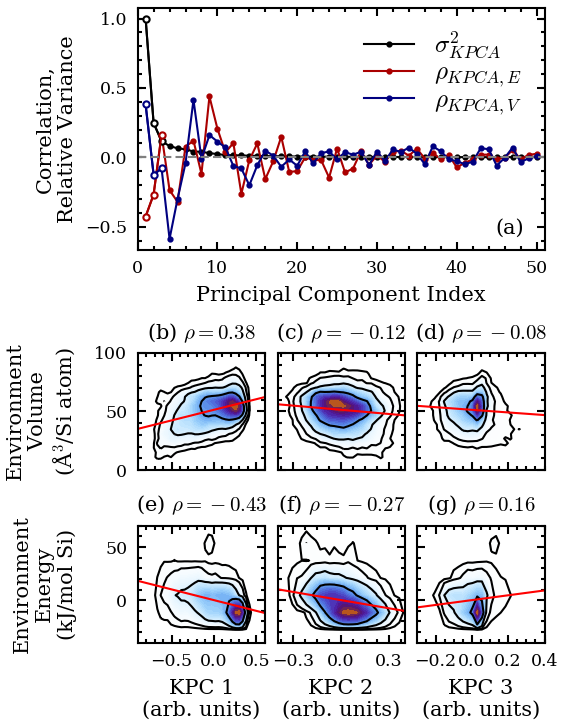

In [61]:
### DEEM 10k, SOAP 3.5 correlation plots ###

# Number of KPCA components and KDE grid divisions
nPCA = 50
n_grid = 40

# Plot labels
plot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

# KPC labels
x = np.arange(1, nPCA+1)

# Initialize figure with Gridspec
fig3 = plt.figure(figsize=(3.5, 5.5))
gs_data = mpl.gridspec.GridSpec(7, 3, height_ratios=(3, 3, 1, 1, 3, 1, 3), hspace=0.1, wspace=0.1)
axs3 = fig3.add_subplot(gs_data[0:2, :])

# Plot explained variance and energy/volume correlation
axs3.plot(x, var3[0:nPCA]/var3[0], marker='o', label=r'$\sigma^2_{KPCA}$')
axs3.plot(x, ccE3[0:nPCA], marker='o', label=r'$\rho_{KPCA, E}$')
axs3.plot(x, ccV3[0:nPCA], marker='o', label=r'$\rho_{KPCA, V}$')

# Reset property cycle
axs3.set_prop_cycle(None)

# Plot empty markers for first three components
axs3.plot(x[0:3], var3[0:3]/var3[0], marker='o', markerfacecolor='w', markersize=3)
axs3.plot(x[0:3], ccE3[0:3], marker='o', markerfacecolor='w', markersize=3)
axs3.plot(x[0:3], ccV3[0:3], marker='o', markerfacecolor='w', markersize=3)

# Axes labels and limits
axs3.set_xlabel('Principal Component Index')
axs3.set_ylabel('Correlation,\nRelative Variance')
axs3.axhline(y=0, linestyle='--', color='grey')
axs3.set_xlim((0, 51))

# Plot labels
axs3.text(0.95, 0.05, '%s' % plot_labels[0], 
          horizontalalignment='right', verticalalignment='bottom', transform=axs3.transAxes)

# Legend
axs3.legend(fontsize='large', labelspacing=0)

# Initialize KDE property grids
yV = np.linspace(volumes_10k_3A.min()-volumes_10k_3A.std(),
                 volumes_10k_3A.max()+volumes_10k_3A.std(), n_grid)
yE = np.linspace(energies_10k_3A.min()-energies_10k_3A.std(),
                 energies_10k_3A.max()+energies_10k_3A.std(), n_grid)

## Volume KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsVol = fig3.add_subplot(gs_data[4, i])
    axsVol_label = fig3.add_subplot(gs_data[3, i])
    
    # Remove borders from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsVol_label.spines[j].set_visible(False)
        
    # Tick parameters
    axsVol_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)

    # Initialize the KDE data grid
    x = np.linspace(kpca_10k_3A[:, i].min()-kpca_10k_3A[:, i].std(),
                    kpca_10k_3A[:, i].max()+kpca_10k_3A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yV)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_10k_3A[:, i], volumes_10k_3A]))
    zz = np.reshape(kde(pos).T, xx.shape)

    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsVol.contourf(xx, yy, zz, levels=levelsf)
    axsVol.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_10k_3A[:, i], volumes_10k_3A)
    axsVol.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsVol.set_ylabel('Environment\nVolume\n' + ur'(\u00c5$^3$/Si atom)')
    else:
        axsVol.set_yticklabels([])
    
    axsVol.set_xticklabels([])
        
    # Set axes limits
    if i == 0:
        axsVol.set_xlim([-0.9, 0.6])
        axsVol.set_xticks([-0.5, 0.0, 0.5])
    elif i == 1:
        axsVol.set_xlim([-0.4, 0.4])
        axsVol.set_xticks([-0.3, 0.0, 0.3])
    else:
        axsVol.set_xlim([-0.3, 0.4])
        axsVol.set_xticks([-0.2, 0.0, 0.2])
        
    axsVol.set_ylim([0, 100])
    
    # Plot labels
    axsVol_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+1], ccV3[i]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsVol_label.transAxes)
    
## Energy KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsE = fig3.add_subplot(gs_data[6, i])
    axsE_label = fig3.add_subplot(gs_data[5, i])
    
    # Remove border from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsE_label.spines[j].set_visible(False)
        
    # Tick parameters
    axsE_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)

    # Initialize the KDE data grid
    x = np.linspace(kpca_10k_3A[:, i].min()-kpca_10k_3A[:, i].std(),
                    kpca_10k_3A[:, i].max()+kpca_10k_3A[:, i].std(), n_grid)
    
    # Compute the KDE
    xx, yy = np.meshgrid(x, yE)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_10k_3A[:, i], energies_10k_3A]))
    zz = np.reshape(kde(pos).T, xx.shape)

    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsE.contourf(xx, yy, zz, levels=levelsf)
    axsE.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_10k_3A[:, i], energies_10k_3A)
    axsE.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsE.set_ylabel('Environment\nEnergy\n(kJ/mol Si)')
    else:
        axsE.set_yticklabels([])
    
    axsE.set_xlabel('KPC %d\n(arb. units)' % (i+1))
    
    # Axes limits
    if i == 0:
        axsE.set_xlim([-0.9, 0.6])
        axsE.set_xticks([-0.5, 0.0, 0.5])
    elif i == 1:
        axsE.set_xlim([-0.4, 0.4])
        axsE.set_xticks([-0.3, 0.0, 0.3])
    else:
        axsE.set_xlim([-0.3, 0.4])
        axsE.set_xticks([-0.2, 0.0, 0.2, 0.4])
        
    axsE.set_ylim([-40, 70])
    
    # Plot labels
    axsE_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+4], ccE3[i]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsE_label.transAxes)

fig3.align_ylabels()
fig3.savefig('../Results/DEEM_10k/kpca_energy-volume-correlation_3.5_10k.pdf', bbox_inches='tight')
plt.show()

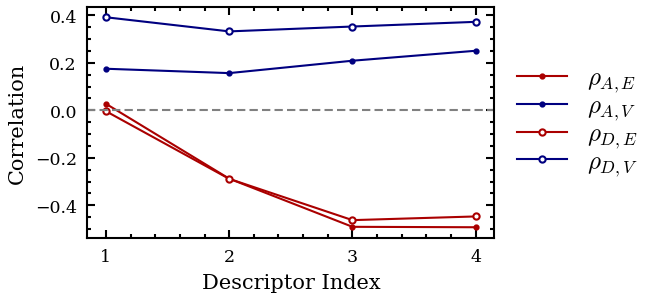

In [62]:
# Correlation coefficient with the classical descriptors

# Descriptor index labels
x = np.arange(1, angles_10k.shape[1]+1)

# Initialize figure and axes
fig3 = plt.figure(figsize=(3.5, 2.0))
axs3 = fig3.add_subplot(1, 1, 1)

# Plot correlation coefficients
axs3.plot(x, ccAE3, marker='o', c=ccycle[1], label=r'$\rho_{A, E}$')
axs3.plot(x, ccAV3, marker='o', c=ccycle[2], label=r'$\rho_{A, V}$')
axs3.plot(x, ccDE3, marker='o', c=ccycle[1], markerfacecolor='w', markersize=3, label=r'$\rho_{D, E}$')
axs3.plot(x, ccDV3, marker='o', c=ccycle[2], markerfacecolor='w', markersize=3, label=r'$\rho_{D, V}$')

# Axes labels and ticks
axs3.set_xlabel('Descriptor Index')
axs3.set_ylabel('Correlation')
axs3.axhline(y=0, linestyle='--', color='grey')
axs3.set_xticks([1, 2, 3, 4])

# Legend
axs3.legend(fontsize='large', labelspacing=0, loc='center left', bbox_to_anchor=(1.0, 0.5))

#fig3.savefig('../Results/DEEM_10k/correlation_classical_3.5_10k.pdf', bbox_inches='tight')
plt.show()

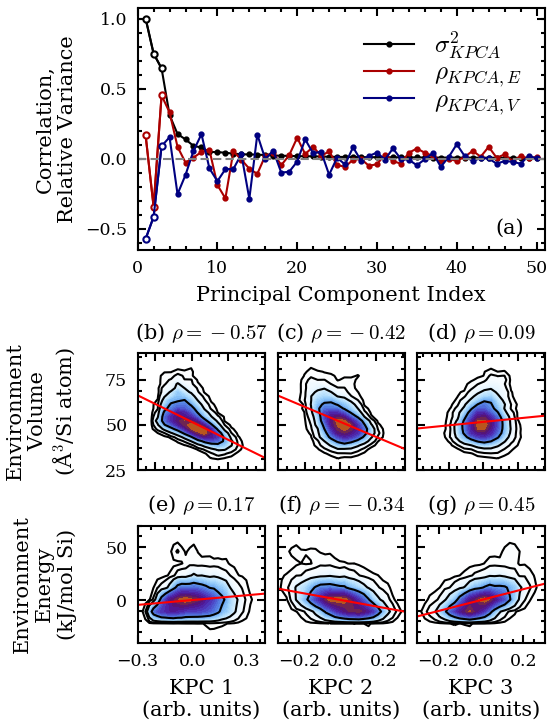

In [63]:
### DEEM 10k, SOAP 6.0 correlation plots ###

# Number of KPCA components and KDE grid divisions
nPCA = 50
n_grid = 40

# Plot labels
plot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

# KPC labels
x = np.arange(1, nPCA+1)

# Initialize figure with Gridspec
fig6 = plt.figure(figsize=(3.5, 5.5))
gs_data = mpl.gridspec.GridSpec(7, 3, height_ratios=(3, 3, 1, 1, 3, 1, 3), hspace=0.1, wspace=0.1)
axs6 = fig6.add_subplot(gs_data[0:2, :])

# Plot explained variance and energy/volume correlation
axs6.plot(x, var6[0:nPCA]/var6[0], marker='o', label=r'$\sigma^2_{KPCA}$')
axs6.plot(x, ccE6[0:nPCA], marker='o', label=r'$\rho_{KPCA, E}$')
axs6.plot(x, ccV6[0:nPCA], marker='o', label=r'$\rho_{KPCA, V}$')

# Reset property cycle
axs6.set_prop_cycle(None)

# Plot empty markers for first three components
axs6.plot(x[0:3], var6[0:3]/var6[0], marker='o', markerfacecolor='w', markersize=3)
axs6.plot(x[0:3], ccE6[0:3], marker='o', markerfacecolor='w', markersize=3)
axs6.plot(x[0:3], ccV6[0:3], marker='o', markerfacecolor='w', markersize=3)

# Axes labels and limits
axs6.set_xlabel('Principal Component Index')
axs6.set_ylabel('Correlation,\nRelative Variance')
axs6.axhline(y=0, linestyle='--', color='grey')
axs6.set_xlim((0, 51))

# Plot labels
axs6.text(0.95, 0.05, '%s' % plot_labels[0], 
          horizontalalignment='right', verticalalignment='bottom', transform=axs6.transAxes)

# Legend
axs6.legend(fontsize='large', labelspacing=0)

# Initialize KDE property grids
yV = np.linspace(volumes_10k_6A.min()-volumes_10k_6A.std(),
                 volumes_10k_6A.max()+volumes_10k_6A.std(), n_grid)
yE = np.linspace(energies_10k_6A.min()-energies_10k_6A.std(), 
                 energies_10k_6A.max()+energies_10k_6A.std(), n_grid)

## Volume KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsVol = fig6.add_subplot(gs_data[4, i])
    axsVol_label = fig6.add_subplot(gs_data[3, i])
    
    # Remove borders from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsVol_label.spines[j].set_visible(False)
    
    # Tick parameters
    axsVol_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)

    # Initialize KDE data grid
    x = np.linspace(kpca_10k_6A[:, i].min()-kpca_10k_6A[:, i].std(),
                    kpca_10k_6A[:, i].max()+kpca_10k_6A[:, i].std(), 20)
    xx, yy = np.meshgrid(x, yV)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_10k_6A[:, i], volumes_10k_6A]))
    zz = np.reshape(kde(pos).T, xx.shape)

    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsVol.contourf(xx, yy, zz, levels=levelsf)
    axsVol.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_10k_6A[:, i], volumes_10k_6A)
    axsVol.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsVol.set_ylabel('Environment\nVolume\n' + ur'(\u00c5$^3$/Si atom)')
    else:
        axsVol.set_yticklabels([])
    
    axsVol.set_xticklabels([])
    
    axsVol.set_ylim([25, 90])
    
    # Plot labels
    axsVol_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+1], ccV6[i]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsVol_label.transAxes)
    
## Energy KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsE = fig6.add_subplot(gs_data[6, i])
    axsE_label = fig6.add_subplot(gs_data[5, i])
    
    # Remove bordder from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsE_label.spines[j].set_visible(False)
        
    # Tick parameters
    axsE_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)

    # Initialize KDE data grid
    x = np.linspace(kpca_10k_6A[:, i].min()-kpca_10k_6A[:, i].std(),
                    kpca_10k_6A[:, i].max()+kpca_10k_6A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yE)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_10k_6A[:, i], energies_10k_6A]))
    zz = np.reshape(kde(pos).T, xx.shape)
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)

    # Plot KDE contours
    axsE.contourf(xx, yy, zz, levels=levelsf)
    axsE.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_10k_6A[:, i], energies_10k_6A)
    axsE.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsE.set_ylabel('Environment\nEnergy\n(kJ/mol Si)')
    else:
        axsE.set_yticklabels([])
    
    axsE.set_xlabel('KPC %d\n(arb. units)' % (i+1))
    
    # Axes limits
    if i == 0:
        axsE.set_xlim([-0.3, 0.4])
        axsE.set_xticks([-0.3, 0.0, 0.3])
    elif i == 1:
        axsE.set_xlim([-0.3, 0.3])
        axsE.set_xticks([-0.2, 0.0, 0.2])
    else:
        axsE.set_xlim([-0.3, 0.3])
        axsE.set_xticks([-0.2, 0.0, 0.2])    
        
    axsE.set_ylim([-40, 70])
    
    # Plot labels
    axsE_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+4], ccE6[i]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsE_label.transAxes)

fig6.align_ylabels()    
fig6.savefig('../Results/DEEM_10k/kpca_energy-volume-correlation_6.0_10k.pdf', bbox_inches='tight')
plt.show()

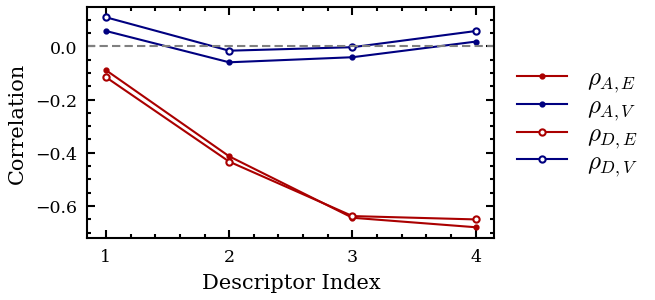

In [64]:
# Correlation coefficient with classical descriptors

# Descriptor index labels
x = np.arange(1, angles_10k.shape[1]+1)

# Initialize figure and axes
fig6 = plt.figure(figsize=(3.5, 2.0))
axs6 = fig6.add_subplot(1, 1, 1)

# Plot correlation coefficients
axs6.plot(x, ccAE6, marker='o', c=ccycle[1], label=r'$\rho_{A, E}$')
axs6.plot(x, ccAV6, marker='o', c=ccycle[2], label=r'$\rho_{A, V}$')
axs6.plot(x, ccDE6, marker='o', c=ccycle[1], markerfacecolor='w', markersize=3, label=r'$\rho_{D, E}$')
axs6.plot(x, ccDV6, marker='o', c=ccycle[2], markerfacecolor='w', markersize=3, label=r'$\rho_{D, V}$')

# Axes labels and ticks
axs6.set_xlabel('Descriptor Index')
axs6.set_ylabel('Correlation')
axs6.axhline(y=0, linestyle='--', color='grey')
axs6.set_xticks([1, 2, 3, 4])

# Legend
axs6.legend(fontsize='large', labelspacing=0, loc='center left', bbox_to_anchor=(1.0, 0.5))

#fig6.savefig('../Results/DEEM_10k/correlation_classical_6.0_10k.pdf', bbox_inches='tight')
plt.show()

# Volume/Energy Correlations in Environments and Frameworks

## 1k data

In [65]:
# Load framework volumes and energies
framework_volumes_1k, framework_energies_1k, structure_idxs_1k = \
    load_framework_data('../Processed_Data/DEEM_1k/atoms.dat')

In [66]:
# 3.5 A SOAP

# Number of KDE grid points
n_grid = 40

# Initialize KDE property grid
vrange = np.linspace(-20, 120, n_grid)
erange = np.linspace(-50, 100, n_grid)
vv, ee = np.meshgrid(vrange, erange)
pos = np.vstack([vv.ravel(), ee.ravel()])

# Compute KDE for environments and frameworks
kde_frameworks_1k = gaussian_kde(np.vstack([framework_volumes_1k, framework_energies_1k]))
z_frameworks_1k = np.reshape(kde_frameworks_1k(pos).T, vv.shape)
kde_environments_1k_3A = gaussian_kde(np.vstack([volumes_1k_3A, energies_1k_3A]))
z_environments_1k_3A = np.reshape(kde_environments_1k_3A(pos).T, vv.shape)

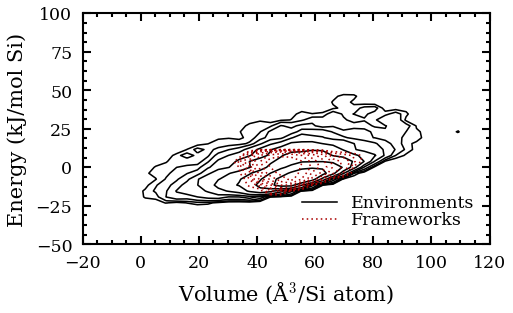

In [67]:
# 3.5 A SOAP
figFramework = plt.figure(figsize=(3.5, 2.0))
axsFramework = figFramework.add_subplot(1, 1, 1)

# Plot KDE contours
n_lvls = 10
lvlsEnv = np.logspace(np.log10(z_environments_1k_3A.max()*1.0E-2), 
                      np.log10(z_environments_1k_3A.max()), n_lvls)
lvlsFrame = np.logspace(np.log10(z_frameworks_1k.max()*1.0E-2), 
                        np.log10(z_frameworks_1k.max()), n_lvls)
contour_environments = axsFramework.contour(vv, ee, z_environments_1k_3A,
                                             linestyles='solid', linewidths=0.75, colors=ccycle[0], 
                                             levels=lvlsEnv, zorder=1)
contour_framework = axsFramework.contour(vv, ee, z_frameworks_1k, 
                                          linestyles='dotted', linewidths=0.75, colors=ccycle[1], 
                                          levels=lvlsFrame, zorder=2)

# Set axes limits
# WARNING: OUTLIERS!
axsFramework.set_ylim([-50, 100])
axsFramework.set_xlim([-20, 120])

# Axes labels
axsFramework.set_xlabel('Volume ' + ur'(\u00c5$^3$/Si atom)')
axsFramework.set_ylabel('Energy (kJ/mol Si)')

# Custom legend
line_env = mpllines.Line2D([0], [0], color=ccycle[0], linewidth=0.75, linestyle='-', label='Environments')
line_frame = mpllines.Line2D([0], [0], color=ccycle[1], linewidth=0.75, linestyle=':', label='Frameworks')
axsFramework.legend(handles=[line_env, line_frame], labelspacing=0, 
                    loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.show()

In [68]:
# 6.0 A SOAP

# Number of KDE grid points
n_grid = 40

# Initialize the KDE property grid
vrange = np.linspace(20, 100, n_grid)
erange = np.linspace(-75, 100, n_grid)
vv, ee = np.meshgrid(vrange, erange)
pos = np.vstack([vv.ravel(), ee.ravel()])

# Compute KDE for environments and frameworks
kde_frameworks_1k = gaussian_kde(np.vstack([framework_volumes_1k, framework_energies_1k]))
z_frameworks_1k = np.reshape(kde_frameworks_1k(pos).T, vv.shape)
kde_environments_1k_6A = gaussian_kde(np.vstack([volumes_1k_6A, energies_1k_6A]))
z_environments_1k_6A = np.reshape(kde_environments_1k_6A(pos).T, vv.shape)

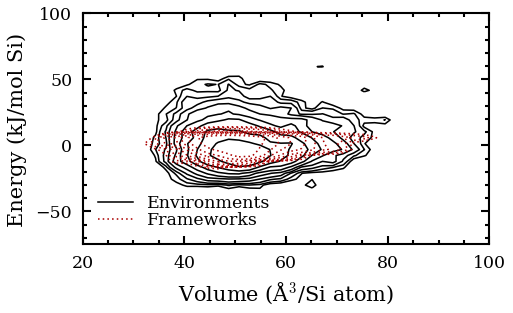

In [69]:
# 6.0 A SOAP
figFramework = plt.figure(figsize=(3.5, 2.0))
axsFramework = figFramework.add_subplot(1, 1, 1)

# Plot KDE contours
n_lvls = 10
lvlsEnv = np.logspace(np.log10(z_environments_1k_6A.max()*1.0E-2), 
                      np.log10(z_environments_1k_6A.max()), n_lvls)
lvlsFrame = np.logspace(np.log10(z_frameworks_1k.max()*1.0E-2), 
                        np.log10(z_frameworks_1k.max()), n_lvls)
contour_environments = axsFramework.contour(vv, ee, z_environments_1k_6A,
                                             linestyles='solid', linewidths=0.75, colors=ccycle[0], 
                                             levels=lvlsEnv, zorder=1)
contour_framework = axsFramework.contour(vv, ee, z_frameworks_1k, 
                                          linestyles='dotted', linewidths=0.75, colors=ccycle[1], 
                                          levels=lvlsFrame, zorder=2)

# Set axes limits
axsFramework.set_ylim([-75, 100])
axsFramework.set_xlim([20, 100])

# Axes labels
axsFramework.set_xlabel('Volume ' + ur'(\u00c5$^3$/Si atom)')
axsFramework.set_ylabel('Energy (kJ/mol Si)')

# Custom legend
line_env = mpllines.Line2D([0], [0], color=ccycle[0], linewidth=0.75, linestyle='-', label='Environments')
line_frame = mpllines.Line2D([0], [0], color=ccycle[1], linewidth=0.75, linestyle=':', label='Frameworks')
axsFramework.legend(handles=[line_env, line_frame], labelspacing=0, 
                    loc='lower left', bbox_to_anchor=(0.0, 0.0))

plt.show()

## 10k data

In [70]:
# Load framework volumes and energies
framework_volumes_10k, framework_energies_10k, structure_idxs_10k = \
    load_framework_data('../Processed_Data/DEEM_10k/atoms.dat')

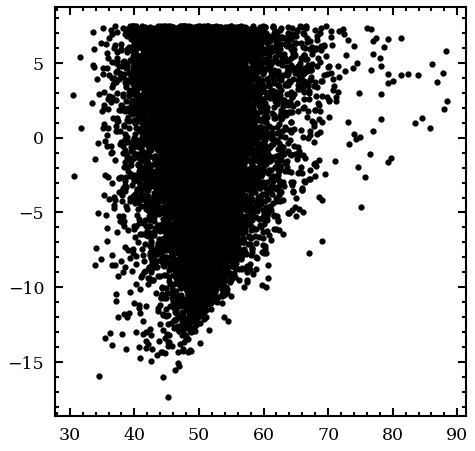

In [71]:
# Plot the framework volumes and energies
plt.scatter(framework_volumes_10k, framework_energies_10k)
plt.show()

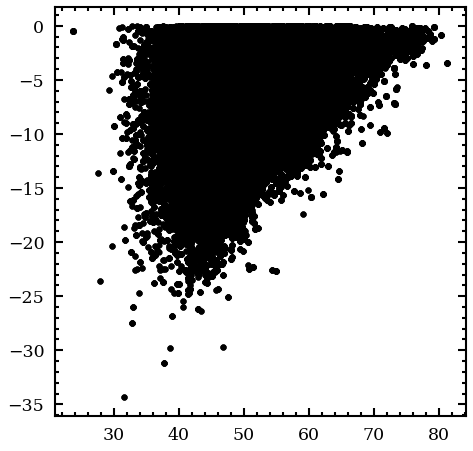

In [72]:
# Plot low-energy environments
plt.scatter(volumes_10k_6A[energies_10k_6A < 0.0], energies_10k_6A[energies_10k_6A < 0.0])
plt.show()

In [73]:
# Is mean framework energy close to the mean of environment contributions?
m = 0
vdiff = np.zeros(framework_volumes_10k.size)

# For each framework, compute mean environment volume
# and compare to the framework volume per Si
for idx, i in enumerate(framework_volumes_10k):
    n_env = np.count_nonzero(structure_idxs_10k == idx)
    vdiff[idx] = i-np.mean(volumes_10k_6A[m:m+n_env])
    m += n_env
    
print np.amax(np.abs(vdiff))
print np.mean(np.abs(vdiff))
print np.std(vdiff)

22.397677299518747
0.8978780497070371
1.5533165975913779


In [74]:
# Is mean framework energy close to the mean of environment contributions?
m = 0
ediff = np.zeros(framework_energies_10k.size)

# For each framework, compute mean environment energy
# and compare to the framework energy per Si
for idx, i in enumerate(framework_energies_10k):
    n_env = np.count_nonzero(structure_idxs_10k == idx)
    ediff[idx] = i-np.mean(energies_10k_6A[m:m+n_env])
    m += n_env
    
print np.amax(np.abs(ediff))
print np.mean(np.abs(ediff))
print np.std(ediff)

3.4065116305511243
0.29090431619457563
0.40125451756262015


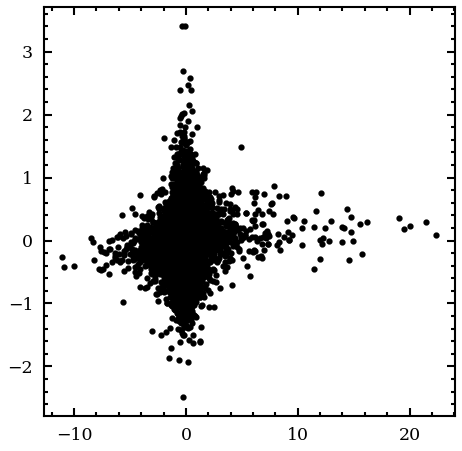

In [75]:
# Plot differences in means
plt.scatter(vdiff, ediff)
plt.show()

In [76]:
# 3.5 A SOAP

# Number of KDE grid points
n_grid = 40

# Initialize KDE property grid
vrange = np.linspace(-40, 120, n_grid)
erange = np.linspace(-75, 150, n_grid)
vv, ee = np.meshgrid(vrange, erange)
pos = np.vstack([vv.ravel(), ee.ravel()])

# Compute KDE for environments and frameworks
kde_frameworks_10k = gaussian_kde(np.vstack([framework_volumes_10k, framework_energies_10k]))
z_frameworks_10k = np.reshape(kde_frameworks_10k(pos).T, vv.shape)
kde_environments_10k_3A = gaussian_kde(np.vstack([volumes_10k_3A, energies_10k_3A]))
z_environments_10k_3A = np.reshape(kde_environments_10k_3A(pos).T, vv.shape)

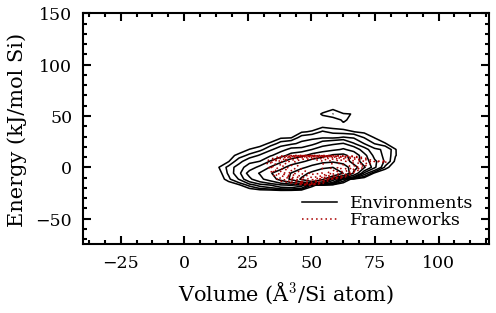

In [77]:
# 3.5 A SOAP
figFramework = plt.figure(figsize=(3.5, 2.0))
axsFramework = figFramework.add_subplot(1, 1, 1)

# Plot KDE contours
n_lvls = 10
lvlsEnv = np.logspace(np.log10(z_environments_10k_3A.max()*1.0E-2), 
                      np.log10(z_environments_10k_3A.max()), n_lvls)
lvlsFrame = np.logspace(np.log10(z_frameworks_10k.max()*1.0E-2), 
                        np.log10(z_frameworks_10k.max()), n_lvls)
contour_environments = axsFramework.contour(vv, ee, z_environments_10k_3A,
                                             linestyles='solid', linewidths=0.75, colors=ccycle[0], 
                                             levels=lvlsEnv, zorder=1)
contour_framework = axsFramework.contour(vv, ee, z_frameworks_10k, 
                                          linestyles='dotted', linewidths=0.75, colors=ccycle[1], 
                                          levels=lvlsFrame, zorder=2)

# Set axes limits
# WARNING: OUTLIERS!
axsFramework.set_ylim([-75, 150])
axsFramework.set_xlim([-40, 120])

# Axes labels
axsFramework.set_xlabel('Volume ' + ur'(\u00c5$^3$/Si atom)')
axsFramework.set_ylabel('Energy (kJ/mol Si)')

# Custom legend
line_env = mpllines.Line2D([0], [0], color=ccycle[0], linewidth=0.75, linestyle='-', label='Environments')
line_frame = mpllines.Line2D([0], [0], color=ccycle[1], linewidth=0.75, linestyle=':', label='Frameworks')
axsFramework.legend(handles=[line_env, line_frame], labelspacing=0, 
                    loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.show()

In [78]:
# 6.0 A SOAP

# Number of KDE grid points
n_grid = 40

# Initialize KDE property grid
vrange = np.linspace(30, 100, n_grid)
erange = np.linspace(-40, 60, n_grid)
vv, ee = np.meshgrid(vrange, erange)
pos = np.vstack([vv.ravel(), ee.ravel()])

# Compute KDE for environments and frameworks
kde_frameworks_10k = gaussian_kde(np.vstack([framework_volumes_10k, framework_energies_10k]))
z_frameworks_10k = np.reshape(kde_frameworks_10k(pos).T, vv.shape)
kde_environments_10k_6A = gaussian_kde(np.vstack([volumes_10k_6A, energies_10k_6A]))
z_environments_10k_6A = np.reshape(kde_environments_10k_6A(pos).T, vv.shape)

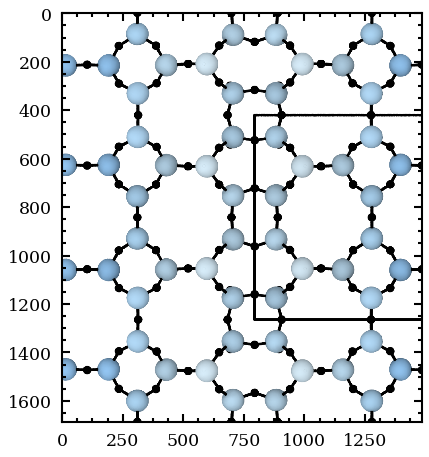

In [109]:
# Load OVITO 1/2 image with Si atoms colored by volume in median-energy structure
img1V = mplimage.imread('../Processed_Data/DEEM_10k/OVITO/medE_2x2_VolumeHalf.png')
plt.imshow(img1V)

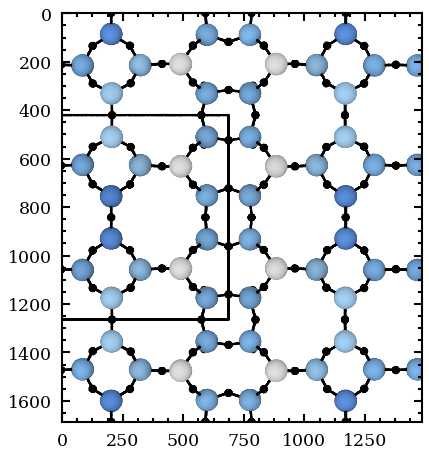

In [112]:
# Load OVITO 1/2 image with Si colored by energy in median-energy structure
img1E = mplimage.imread('../Processed_Data/DEEM_10k/OVITO/medE_2x2_EnergyHalf.png')
plt.imshow(img1E)

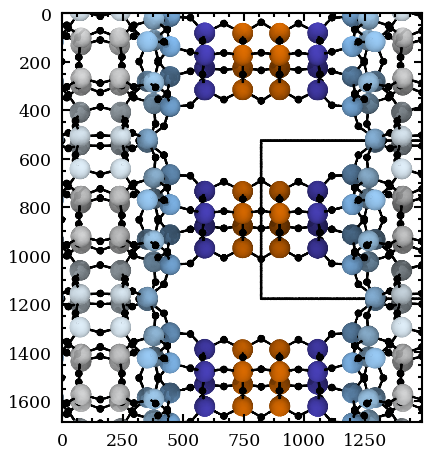

In [113]:
# Load OVITO 1/2 image with Si colored by volume in highest-volume structure
img2V = mplimage.imread('../Processed_Data/DEEM_10k/OVITO/highVol_2x2_VolumeHalf.png')
plt.imshow(img2V)

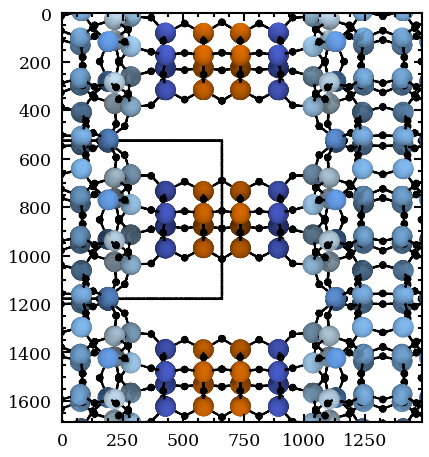

In [114]:
# Load OVITO 1/2 image with Si colored by energy in highest-volume structure
img2E = mplimage.imread('../Processed_Data/DEEM_10k/OVITO/highVol_2x2_EnergyHalf.png')
plt.imshow(img2E)

In [81]:
# Color cycle
print ccycle

['#000000', '#aa0000', '#000080', '#008000', '#800080', '#808080', '#ffcc00', '#d45500', '#c83771', '#c0c0c0']


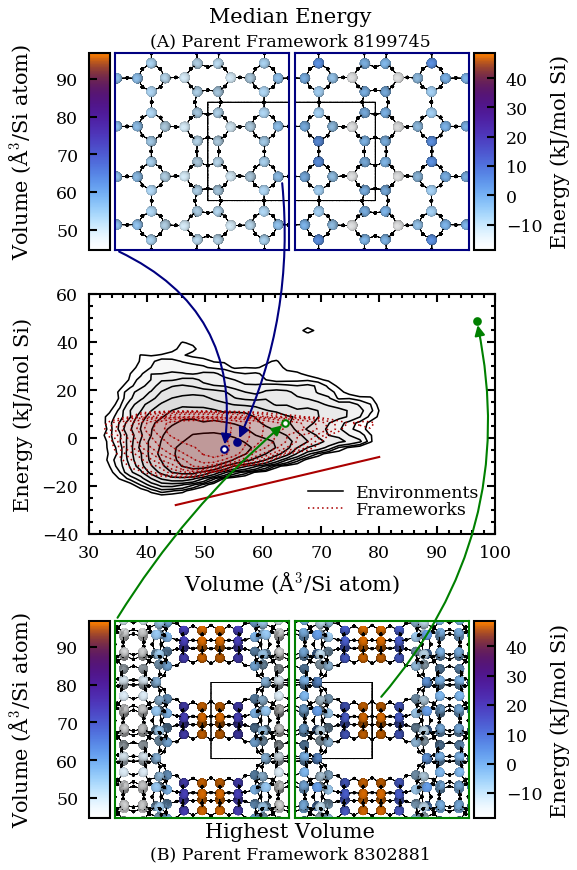

In [151]:
# Environment and framework image for 10k, 6.0 A SOAP

# Initialize figure
figFramework = plt.figure(figsize=(3.5, 7.0))

# Build subplot arrangement with Gridspec
gs_data = mpl.gridspec.GridSpec(11, 4, hspace=0.0, wspace=0.05, 
                                height_ratios=(0.1, 0.9, 0.1, 
                                               0.1, 1.1, 0.1, 0.1, 0.1, 
                                               0.1, 0.9, 0.1),
                                width_ratios=(0.12, 1.0, 1.0, 0.12))

# Initialize axes
axsFramework = figFramework.add_subplot(gs_data[4, :])

axs11 = figFramework.add_subplot(gs_data[1, 1])
axs12 = figFramework.add_subplot(gs_data[1, 2])

axs21 = figFramework.add_subplot(gs_data[-2, 1])
axs22 = figFramework.add_subplot(gs_data[-2, 2])

vaxs1 = figFramework.add_subplot(gs_data[1, 0])
vaxs2 = figFramework.add_subplot(gs_data[-2, 0])

caxs1 = figFramework.add_subplot(gs_data[1, -1])
caxs2 = figFramework.add_subplot(gs_data[-2, -1])

# Turn off border for dummy gridspec axes
# that are just used for spacing
for side in ['top', 'bottom', 'right', 'left']:
    for ax in [axs11, axs12]:
        ax.spines[side].set_color(ccycle[2])
    for ax in [axs21, axs22]:
        ax.spines[side].set_color(ccycle[3])

# Show the OVITO images
axs11.imshow(img1V, aspect='equal')
axs12.imshow(img1E, aspect='equal')
axs21.imshow(img2V, aspect='equal')
axs22.imshow(img2E, aspect='equal')

# Tick parameters
for ax in [axs11, axs12, axs21, axs22]:
    ax.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False,
                   labelleft=False, labelright=False, labelbottom=False, labeltop=False)

# Plot KDE contours
n_lvls = 10
lvlsEnv = np.logspace(np.log10(z_environments_10k_6A.max()*1.0E-2), 
                      np.log10(z_environments_10k_6A.max()), n_lvls) # Contours start at 0.01
lvlsFrame = np.logspace(np.log10(z_frameworks_10k.max()*1.0E-2), 
                        np.log10(z_frameworks_10k.max()), n_lvls) # Contours start at 0.01
contour_environments = axsFramework.contour(vv, ee, z_environments_10k_6A,
                                             linestyles='solid', linewidths=0.75, colors=ccycle[0], 
                                             levels=lvlsEnv, zorder=1)
contour_framework = axsFramework.contour(vv, ee, z_frameworks_10k, 
                                          linestyles='dotted', linewidths=0.75, colors=ccycle[1], 
                                          levels=lvlsFrame, zorder=2)

# Plot filled KDE contours with scaled transparency
# (more opaque at higher density)
alphas = np.linspace(np.log10(z_environments_10k_6A.max()*1.0E-2), 
                      np.log10(z_environments_10k_6A.max()), n_lvls) # Contours start at 0.01
alphas = (alphas-np.amin(alphas))/(np.amax(alphas)-np.amin(alphas))

frameworkColors = np.zeros((alphas.size, 4))
environmentColors = np.zeros((alphas.size, 4))

for adx, a in enumerate(alphas):
    frameworkColors[adx, :] = mplcolors.to_rgba(ccycle[1])
    environmentColors[adx, :] = mplcolors.to_rgba(ccycle[0])

frameworkColors[:, 3] = alphas*0.25
environmentColors[:, 3] = alphas*0.25

contourf_environments = axsFramework.contourf(vv, ee, z_environments_10k_6A,
                                             colors=environmentColors, levels=lvlsEnv, zorder=1)
contourf_framework = axsFramework.contourf(vv, ee, z_frameworks_10k,
                                          colors=frameworkColors, levels=lvlsFrame, zorder=2)

# Plot the guiding line
dummyx = np.linspace(45, 80, 2)
dummyy = np.linspace(-28, -8, 2)
axsFramework.plot(dummyx, dummyy, linestyle='-', color=ccycle[1])

# Axes limits
axsFramework.set_ylim([-40, 60])
axsFramework.set_xlim([30, 100])

# Axes labels
axsFramework.set_xlabel('Volume ' + ur'(\u00c5$^3$/Si atom)')
axsFramework.set_ylabel('Energy (kJ/mol Si)')

# Custom legend
line_env = mpllines.Line2D([0], [0], color=ccycle[0], linewidth=0.75, linestyle='-', label='Environments')
line_frame = mpllines.Line2D([0], [0], color=ccycle[1], linewidth=0.75, linestyle=':', label='Frameworks')
axsFramework.legend(handles=[line_env, line_frame], labelspacing=0, 
                    loc='lower right', bbox_to_anchor=(1.0, 0.0))

# Plot point of median-energy environment
axsFramework.scatter(volumes_10k_6A[236960], energies_10k_6A[236960], marker='o', s=10, c=ccycle[2], zorder=3)

# Plot point of highest-volume environment
axsFramework.scatter(volumes_10k_6A[464212], energies_10k_6A[464212], marker='o', s=10, c=ccycle[3], zorder=3)

# Plot point of framework with median-energy environment
axsFramework.scatter(framework_volumes_10k[6242], framework_energies_10k[6242], 
                     marker='o', s=10, edgecolor=ccycle[2], facecolor='w', zorder=3)

# Plot point of framework with highest-volume environment
axsFramework.scatter(framework_volumes_10k[9465], framework_energies_10k[9465], 
                     marker='o', s=10, edgecolor=ccycle[3], facecolor='w', zorder=3)

# Create arrows to the environments and frameworks
axs11.annotate('', xy=(volumes_10k_6A[236960], energies_10k_6A[236960]),
              xycoords=axsFramework.transData, 
              xytext=(0.96, 0.36), textcoords=axs11.transAxes, zorder=3,
                      arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=-0.14', color=ccycle[2]))
axs11.annotate('', xy=(framework_volumes_10k[6242], framework_energies_10k[6242]),
              xycoords=axsFramework.transData, 
              xytext=(0.0, 0.0), textcoords=axs11.transAxes, zorder=3,
                      arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=-0.37', color=ccycle[2]))

axs22.annotate('', xy=(volumes_10k_6A[464212], energies_10k_6A[464212]), 
              xycoords=axsFramework.transData, 
              xytext=(0.48, 0.60), textcoords=axs22.transAxes, zorder=3,
              arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=0.25', color=ccycle[3]))
axs21.annotate('', xy=(framework_volumes_10k[9465], framework_energies_10k[9465]), 
              xycoords=axsFramework.transData, 
              xytext=(0.0, 1.0), textcoords=axs21.transAxes, zorder=3,
              arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=-0.08', color=ccycle[3]))

# Plot labels
axs11.text(1.01, 1.14, 'Median Energy', horizontalalignment='center', verticalalignment='bottom',
         transform=axs11.transAxes)
axs11.text(1.01, 1.02, '(A) Parent Framework 8199745', horizontalalignment='center', verticalalignment='bottom',
         transform=axs11.transAxes, fontsize='small')

axs21.text(1.01, -0.02, 'Highest Volume', horizontalalignment='center', verticalalignment='top',
         transform=axs21.transAxes)
axs21.text(1.01, -0.14, '(B) Parent Framework 8302881', horizontalalignment='center', verticalalignment='top',
         transform=axs21.transAxes, fontsize='small')

# Set up the colorbars to match the OVITO color scales
normE1 = mplcolors.Normalize(vmin=-18.579, vmax=48.542)
smE1 = mpl.cm.ScalarMappable(norm=normE1, cmap='cbarHot')
smE1.set_array([])
cbE1 = figFramework.colorbar(smE1, cax=caxs1)
cbE1.ax.tick_params(which='minor', right=False)
#cbE1.set_ticks([-16, -12, -8, -4, 0, 4])
cbE1.set_label('Energy (kJ/mol Si)')

normE2 = mplcolors.Normalize(vmin=-18.579, vmax=48.542)
smE2 = mpl.cm.ScalarMappable(norm=normE2, cmap='cbarHot')
smE2.set_array([])
cbE2 = figFramework.colorbar(smE2, cax=caxs2)
cbE2.ax.tick_params(which='minor', right=False)
#cbE2.set_ticks([-10, 0, 10, 20, 30, 40, 50])
cbE2.set_label('Energy (kJ/mol Si)')

normV1 = mplcolors.Normalize(vmin=44.715, vmax=96.793)
smV1 = mpl.cm.ScalarMappable(norm=normV1, cmap='cbarHot')
smV1.set_array([])
cbV1 = figFramework.colorbar(smV1, cax=vaxs1)
cbV1.ax.tick_params(which='minor', right=False)
cbV1.ax.tick_params(which='major', left=True, right=False, labelleft=True, labelright=False)
#cbV1.set_ticks([50, 60, 70, 80, 90])
cbV1.set_label('Volume ' + ur'(\u00c5$^3$/Si atom)', labelpad=-54)

normV2 = mplcolors.Normalize(vmin=44.715, vmax=96.793)
smV2 = mpl.cm.ScalarMappable(norm=normV2, cmap='cbarHot')
smV2.set_array([])
cbV2 = figFramework.colorbar(smV2, cax=vaxs2)
cbV2.ax.tick_params(which='minor', right=False)
cbV2.ax.tick_params(which='major', left=True, right=False, labelleft=True, labelright=False)
#cbV2.set_ticks([50, 60, 70, 80, 90])
cbV2.set_label('Volume ' + ur'(\u00c5$^3$/Si atom)', labelpad=-54)

plt.savefig('../Results/DEEM_10k/environments-frameworks_6.0_10k.pdf', bbox_inches='tight', dpi=600)

plt.show()

In [83]:
# Linear regression on rings
rings = np.loadtxt('../Processed_Data/DEEM_10k/Rings/Short/Distribution/rings.dat')

In [84]:
# Regression on environment properties
w_env = np.dot(np.linalg.pinv(rings - np.mean(rings, axis=0)), volumes_10k_6A - np.mean(volumes_10k_6A))
print w_env/np.linalg.norm(w_env)

[ 0.00000000e+00  2.50383952e-16  7.70251538e-01  4.18658888e-01
 -2.55492678e-01 -1.93796556e-01 -3.13450261e-01 -6.21745588e-02
 -9.25567341e-02  2.80888768e-02  0.00000000e+00  1.30886263e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


[[ 3.         52.16787967  7.71561103]
 [ 4.         57.27362289  9.32685245]
 [ 5.         52.33589487  7.76749852]
 [ 6.         50.74648177  7.16214151]
 [ 7.         47.94990209  6.04735565]
 [ 8.         52.31297985  7.16481875]
 [ 9.         49.42380892  8.45490578]
 [10.         52.50400011  7.95252875]
 [12.         55.93680759  4.88637183]]
[[ 3.         11.21867302 19.46196488]
 [ 4.          4.55070213 11.27643386]
 [ 5.          0.93153041  9.82656   ]
 [ 6.         -1.30114105  9.99785088]
 [ 7.          1.00287536 10.10909752]
 [ 8.          0.4067577   8.96555934]
 [ 9.          4.51010788 10.49544712]
 [10.          1.90395492  9.19628272]
 [12.          5.17286333  7.08682489]]


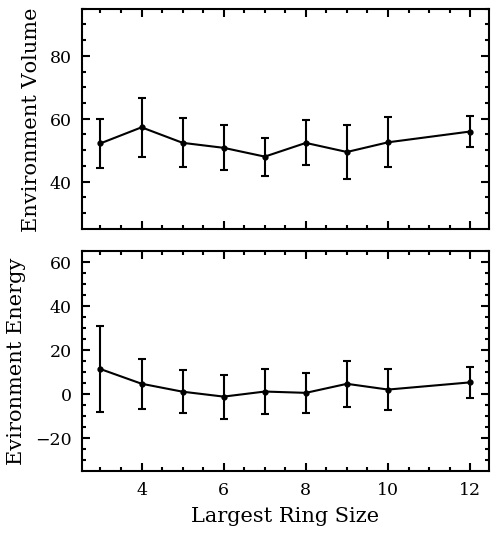

In [85]:
# Plot environment properties associated with
# the largest ring size to which the central Si belongs

# Find the largest ring
largest_rings = np.zeros(rings.shape[0], dtype=np.int)
for i in range(0, rings.shape[0]):
    largest_rings[i] = np.amax(np.nonzero(rings[i, :])[0])+1

# Initialize matrices to store the ring sizes
# and property data
min_rings = np.amin(largest_rings)
max_rings = np.amax(largest_rings)
statsV = np.zeros(((max_rings-min_rings+1), 3))
statsE = np.zeros(((max_rings-min_rings+1), 3))

# Compute mean and std. dev. of the properties
# at each largest ring size
for idx, i in enumerate(range(min_rings, max_rings+1)):
    ringV = volumes_10k_6A[largest_rings == i]
    ringE = energies_10k_6A[largest_rings == i]
    statsV[idx, 0] = i
    statsE[idx, 0] = i
    if ringV.size > 0:
        statsV[idx, 1] = np.mean(ringV)
        statsV[idx, 2] = np.std(ringV)
    if ringE.size > 0:
        statsE[idx, 1] = np.mean(ringE)
        statsE[idx, 2] = np.std(ringE)

# Remove ring size for which no property values exist
statsV = np.delete(statsV, 8, axis=0)
statsE = np.delete(statsE, 8, axis=0)
print statsV
print statsE

# Initialize figure and axes
figRings = plt.figure(figsize=(3.5, 4.0))
axsV = figRings.add_subplot(2, 1, 1)
axsE = figRings.add_subplot(2, 1, 2)

# Plot the data with error bars of the standard deviation
axsV.scatter(statsV[:, 0], statsV[:, 1])
axsV.errorbar(statsV[:, 0], statsV[:, 1], yerr=statsV[:, 2])

axsE.scatter(statsE[:, 0], statsE[:, 1])
axsE.errorbar(statsE[:, 0], statsE[:, 1], yerr=statsE[:, 2])

# Axes labels
axsE.set_xlabel('Largest Ring Size')
axsV.set_ylabel('Environment Volume')
axsE.set_ylabel('Evironment Energy')

# Axes limits
axsE.set_ylim([-35, 65])
axsV.set_ylim([25, 95])

# Tick parameters
axsV.tick_params(axis='x', labelbottom=False)

figRings.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

In [86]:
# Linear regression on rings
rings = np.loadtxt('../Processed_Data/DEEM_10k/Rings/Short/Binary/rings.dat')

In [87]:
# Regression on environment properties
w_env = np.dot(np.linalg.pinv(rings - np.mean(rings, axis=0)), volumes_10k_6A - np.mean(volumes_10k_6A))
print w_env/np.linalg.norm(w_env)

[ 0.00000000e+00  1.16405515e-17  3.47766799e-01  4.03331166e-01
 -3.32156986e-01 -3.93457948e-01 -5.00142058e-01 -7.35154894e-02
 -2.96925604e-01  4.46463501e-02  0.00000000e+00  3.24869339e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


In [88]:
# Linear regression on rings
rings = np.loadtxt('../Processed_Data/DEEM_10k/Rings/King/Distribution/rings.dat')

In [89]:
# Regression on environment properties
w_env = np.dot(np.linalg.pinv(rings - np.mean(rings, axis=0)), volumes_10k_6A - np.mean(volumes_10k_6A))
print w_env/np.linalg.norm(w_env)

[ 0.00000000e+00  1.08221022e-16  8.56829466e-01  4.79720831e-01
 -4.56183948e-02 -6.55376804e-02 -1.45229236e-01 -5.48462649e-02
 -3.87528599e-02  8.36717494e-03 -1.14274729e-03 -6.05162866e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


In [90]:
# Linear regression on rings
rings = np.loadtxt('../Processed_Data/DEEM_10k/Rings/King/Binary/rings.dat')

In [91]:
# Regression on environment properties
w_env = np.dot(np.linalg.pinv(rings - np.mean(rings, axis=0)), volumes_10k_6A - np.mean(volumes_10k_6A))
print w_env/np.linalg.norm(w_env)

[ 0.00000000e+00  3.62175972e-16  5.79865855e-01  6.56238151e-01
 -7.48689695e-02  4.81353563e-02 -3.49155428e-01 -9.46215176e-02
 -7.44746426e-02  1.09376485e-01  9.98052814e-02 -2.58555946e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
